# Predict whether or not a tweet is about a real disaster 

References:
    
    https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=7219856

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression

# Data Overview

There are 7,613 training data points and 3,263 test datapoints

In [2]:
def df_shape(filename):
    """
        Return the shape (row,columns) of the dataset in the .csv file
        
        @P: filename (string) of a csv data set file
        @R: tuple of dataframe size
        
    """
    df=pd.read_csv(filename)
    return df.shape

def hist_rel_freq(filename,columnName,mx_val):
    """
        Save a relative frequency of a specific column with values that are numerical
        
        @P: filename: (csv) the training data file
            columnName: (dtring) the name of the column of interest
            mx_val: (int) the max range for the x-axis
            
    """
    df=pd.read_csv(filename)
    fig, ax = plt.subplots()
    g=sns.histplot(data=df, x=columnName, stat="percent", discrete=True, ax=ax)
    ax.set_xlim(-1,mx_val+1)
    ax.set_xticks(range(0,mx_val+1))
    plt.savefig('output/dist_{}.png'.format(columnName))
    print("\n Column: {} Relative Frequency \n".format(columnName),df[columnName].value_counts(normalize=True))

The shape of the training data is (7613, 5) 
The shape of the test data is (3263, 4) 

 Column: target Relative Frequency 
 0    0.57034
1    0.42966
Name: target, dtype: float64


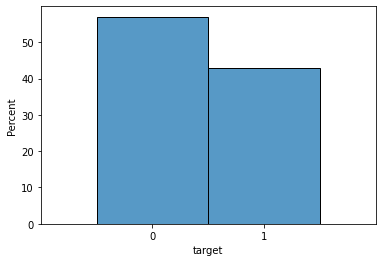

In [3]:
print("The shape of the training data is {} ".format(df_shape("input/train.csv")))
print("The shape of the test data is {} ".format(df_shape("input/test.csv")))
hist_rel_freq("input/train.csv","target",1)

# Pre-process

• Convert all the words to lowercase

• Lemmatize all thewords (i.e., convert every word to its root so that all of “running,” “run,” and “runs” are converted to “run” and and all of “good,” “well,” “better,” and “best” are converted to “good”; this is easily done using nltk.stem) - (CHOSE NOT TO LEMMATIZE, TO PRESERVE MEANING OF TEXT - CONSIDER WRITING MY OWN FUNCTION)

• Strip punctuation

• Strip the stop words, e.g., “the”, “and”, “or” (ADDITIONAL STOP WORDS?)

• Strip @ and urls (It’s Twitter.)

• Something else? Tell us about it (SPELL CHECK, Repeated letters removal, convert numbers to spelling)

In [4]:
def make_lower(col_name,dataF):
    """
        Convert all words to lowercase.
        
        @P: 
        col (string): Name of column in a dataframe that contains text data
        dataF (dataframe): Dataframe with the text data that needs modifying
        
    """
    dataF[col_name]=dataF[col_name].str.lower()
    
def remove_punctuation(col_name,dataF):
    """
        Remove the punctuation in a column with text data.
        
        @P: 
        col (string): Name of column in a dataframe that contains text data
        dataF (dataframe): Dataframe with the text data that needs modifying
        
    """
    
    #Regex to identify anything that is not a word or string
    dataF[col_name]=dataF[col_name].str.replace(r'[^\w\s]+','') 

def remove_tag(txt_col):
    """
        Remove the @'username' in a column with text data.
        
        @P: 
        txt_col (series): Dataframe column that contains text data.
        
        @R:
        s (string): String without @'username'.
        
    """
    words = word_tokenize(txt_col)
    
    j=-1
    w_arr=[]
    for i in range(len(words)):
        if words[i]=='@': j=i+1
        
        if words[i]!='@' and i!=j: w_arr.append(words[i])
    
    s=" ".join(w_arr)
    return s

def remove_url(txt_col):
    """
        Remove the url in a column with text data.
        
        @P: 
        txt_col (series): Dataframe column that contains text data.
        
        @R:
        s (string): String without url.
        
    """
    words = word_tokenize(txt_col)
    w_arr=[ w for w in words if not w.startswith('http')]
    s=" ".join(w_arr)
    return s

def lematize_txt(txt_col):
    """
        Stem words.
        
        @P: 
        txt_col (series): Dataframe column that contains text data.
        
        @R:
        s (string): String of lematized text
        
    """
    
    ps = PorterStemmer()
    words = word_tokenize(txt_col)
    w_arr=[ps.stem(w) for w in words]
    s=" ".join(w_arr)
    return s

def rmv_stop_wrds(txt_col):
    """
        Remove stop words.
        
        @P: 
        txt_col (series): Dataframe column that contains text data.
        
        @R:
        s (string): String of text without stop words.
        
    """
    
    stop_words = set(stopwords.words('english'))
    words = word_tokenize(txt_col)
    w_arr=[w for w in words if not w.lower() in stop_words]
    s=" ".join(w_arr)
    return s

In [5]:
df=pd.read_csv("input/train.csv")

make_lower("text",df)
df['text'] = df.apply(lambda x: remove_tag(x['text']),axis=1)
remove_punctuation("text",df)
df['text'] = df.apply(lambda x: rmv_stop_wrds(x['text']),axis=1)
df['text'] = df.apply(lambda x: remove_url(x['text']),axis=1)

df.to_csv("output/ck_pre_proc.csv")

# Split Training Data 

In [6]:
X=df.drop('target', axis=1, inplace=False)
y=df['target']
X_train, X_validate, y_train, y_validate = train_test_split(df, y, test_size=0.3, random_state=42)

# Bag of Words Model

In [7]:
#Determine the threshold using the 80-20 rule. 
#Plot the relative distribution of the words in the dataset

#PLAY WITH THE THRESHOLD

def all_docs(df,txt_col):
    """
        Convert txt_col to list.
        
        @P:
        col (series): the column in a dataframe containing the text data
        voc_dict (dict): a dictionary where the keys as words and the frequency as the element
        
        @R:
        voc_dict (dict): updated dictionary with the keys as words and the frequency as the element
    """
    sent_arr=df[txt_col].to_list()
    all_tok_lst=[word_tokenize(s) for s in sent_arr]
    
    distinct_tok=[list(set(a)) for a in all_tok_lst]
    
    all_toks=[]
    for s in distinct_tok: all_toks.extend(s)
    
    voc_dict={}
    for w in all_toks:
        if w not in voc_dict: voc_dict[w]=1
        else: voc_dict[w]+=1
    
    return voc_dict, len(sent_arr)

def freq_lst(v_dict,total):
    """
        Relative Frequency of the words in a list for sorting and percentiling
        
        @P:
        v_dict (dict): a dictionary with relative frequency
        
        @R:
        voc_list (list): a list with tuples of (words,relative_frequency)
    """
    
    voc_list=[(k,v_dict[k]/total) for k in v_dict]
    return voc_list

def sort_lst(freq_lst):
    """
        Sort word frequency list by the frequency of the words in the list.
        
        @P:
        freq_lst (list): list of tuples - (word,frequency)
        
        @R:
        w_list (list): a list of tuples-(word,frequency) that are sorted by frequency
    """
    
    return sorted(freq_lst, key=lambda tup: tup[1], reverse=True)

def pareto80(srt_freq,total):
    """
        Find a desired percentile in the dataset.
        
        @p:
        srt_freq (list): sorted list of words with relative frequency
        
        @r:
        relative frequency at of the word at the 80% mark (pareto)
        
    """
    t=0.0
    for w,f in srt_freq:
        t+=f
        if t>=0.8:return round(f*total)
    

def target_thresh(thresh,v):
    """
        Create a vocab dictionary that has words that show up in 'thresh' number of tweets
        
        @p:
        thresh (int): desired threshold
        v (dict): all tokens in the dataset
        
        @r:
        vocab (dict): a dictionary with words that have the desired frequency
        
    """
    
    print(len(v))
    
    vocab={}
    for w in v:
        if v[w]>thresh: vocab[w]=v[w]
            
    return vocab

def bow(M,df,txt_col):
    """
        Fit count vectorizer to the training dataset.
        
        @p:
        M (int): desired threshold
        df (datframe): training data
        txt_col (string): name of the column in the dataframe with text data
        
        @r:
        vectorizer (vectorizer): trained vectorizer
        
    """
    vectorizer = CountVectorizer(binary=True,min_df=M)
    document=df[txt_col].to_list()
    vectorizer.fit(document)
    
    return vectorizer
            
def encoder(vect,df,txt_col):
    """
        Encode text data with encoder.
        
        @p:
        vect (vectorizer): trained vectorizer
        df (datframe): dataframe containing the information needed to be encoded
        txt_col (string): name of the column in the dataframe with text data
        
        @r:
        vector (scipy.sparse.csr.csr_matrix): encoded text data
        
    """
    
    document=df[txt_col].to_list()
    vector = vect.transform(document)
    
    return vector
    
vocab_dict,total_tweets=all_docs(X_train,'text')
vocab_freq_list=freq_lst(vocab_dict,total_tweets)
v_freq_lst_sort=sort_lst(vocab_freq_list)

threshold=pareto80(v_freq_lst_sort,total_tweets)

final_v_dict=target_thresh(threshold,vocab_dict)

train_vectorizer=bow(threshold,X_train,'text')

v_text=encoder(train_vectorizer,X_train,'text')

15775


# Logistic Regression

In [9]:
lf = LogisticRegression(penalty='none').fit(v_text, y_train)